
# Andrew Ng's Machine Learning MOOC: Week 7: Support Vector Machines

# Programming Exercise 6

## 0. Introduction
This notebook contains my solutions to the programming exercise for week 7 of Andrew Ng's famous Machine Learning MOOC on Coursera (https://www.coursera.org/learn/machine-learning).

This week, we will be using support vector machines (SVMs) to build a spam classifier. This is a supervised learning task - we will take labelled data, where the labels denote whether the data belong to one class or another (in this case, "spam" or "not spam". We will then create a model predicts which class a data point - or, more usefully, new data points - belong to.

Now, the course requires submission of programming exercises in either the MATLAB or OCTAVE programming language.
However since:
- I already code in Python for various web development and data science projects, and
- Python is the pre-eminent language currently used in data science and machine learning (and MATLAB and OCTAVE don't seem to be used anywhere near as much)
I decided it would be more valuable to me to use Python to complete the programming exercises.

I was therefore very pleased to find the following source, which has kindly written a set of python scripts to allow one to create Python implementations of the programming exercises for the course, and still submit them for scoring by the MOOC: https://github.com/dibgerge/ml-coursera-python-assignments

Thanks very much `dibgerge!`

In addition to the course's own lecture materials, I also used a number of other sources to help me solve the programming exercises. These include:

#### Other courses I've completed:
- Harvard's Using Python for Research on edX: https://www.edx.org/course/using-python-for-research
- UC San Diego's Python for Data Science, also on edX: https://www.edx.org/course/python-for-data-science-2
- MIT's Introduction to Computational Thinking and Data Science I and II, also on edX: https://www.edx.org/course/introduction-to-computational-thinking-and-data-4
- Imperial College London's Mathematics for Machine Learning I-III on Coursera: https://www.coursera.org/specializations/mathematics-machine-learning

#### Books:
- Python Machine Learning by Sebastian Raschka and Vahid Mirjalili: https://sebastianraschka.com/books.html

#### Blogs and websites
I found this blog a very useful reference:
https://www.johnwittenauer.net/machine-learning-exercises-in-python-part-6/

And of course, there's always StackOverflow!

One thing that struck me, looking at all of these different resources, is how many different ways there are to implement basically the same code in python, even using numpy and pandas dataframes! And that's before we think about object-oriented implementations, or using libraries such as scikitlearn.

OK, now that the introduction is complete, let's get started with some imports. You can find instructions on how to install required libraries in the README file in `dibgerge`'s github repository.

In [1]:
# used for manipulating directory paths
import os

# Scientific and vector computation for python
import numpy as np

# Pandas for maniupliation of large arrays of data
import pandas as pd

# Import regular expressions to process emails
import re

# Plotting library
from matplotlib import pyplot as plt

# Seaborn plot formatting
import seaborn as sb

# Machine learning library
from sklearn import svm

# Optimization module in scipy
from scipy import optimize

# will be used to load MATLAB mat datafile format
from scipy.io import loadmat

# time library
import time

# library written for this exercise providing additional functions for assignment submission, and others
import utils

# define the submission/grader object for this exercise
grader = utils.Grader()

# tells matplotlib to embed plots within the notebook
%matplotlib inline

## 1 Support Vector Machines

In the first half of this exercise, we will be using support vector machines (SVMs) with various example 2D datasets. We are going to experiment with these datasets to build our intuition of how SVMs work and how to use a so-called "*Gaussian kernel*" with SVMs. In the second half of the exercise, we will use support
vector machines to build a spam classifier.

### 1.1.1 Example Dataset 1 - using Utility Functions

We will begin by with a 2D example dataset which can be separated by a linear boundary. Let's start by loading and plotting the data, using some helpful functions that `dibgerge` has provided for us:

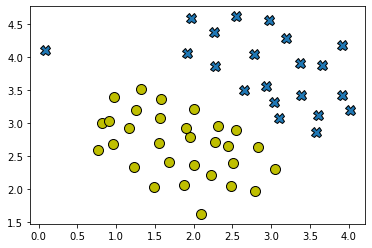

In [2]:
# Load from ex6data1
# You will have X, y as keys in the dict data
data = loadmat(os.path.join('Data', 'ex6data1.mat'))
X, y = data['X'], data['y'][:, 0]

# Plot training data
utils.plotData(X, y)

In this dataset, the positions of the positive examples (indicated with `x`) and the negative examples (indicated with `o`) suggest a natural separation indicated by the gap. However, notice that there is an outlier positive example `x` on the far left at about (0.1, 4.1). As we continue, we will see how this outlier affects the SVM decision boundary - in particular depending on the values we choose for the regularization parameter, $C$:
- We can think of $C$ as controlling the penalty for mis-classified training examples.
- A large value of $C$ results in the SVM trying to classify all of the training examples correctly - at the cost of increasing the chance of over-fitting the training data.
- $C$ takes a positive value.
- It plays a role analogous to $1/\lambda$, where $\lambda$ is the regularization parameter that we were using previously for logistic regression.

Below, we can try out using different values of the $C$ parameter with SVMs. We are not going to write our own code for the SVM; instead we will use pre-built libraries to do this for us. However, we will write some code for some of the *kernels* we'll want to use with the SVM, in section 1.2 below.

The following cell will run the SVM training (with $C=1$) using SVM software that `dibgerge` included with the starter code (function `svmTrain` within the `utils` module of this exercise).

When $C=1$, we should find that the SVM puts the decision boundary in the gap between the two datasets - with a large margin between the decision boundary and the closest data points from each class (these points are called the "*support vectors*"). The algorithm we have fitted also *misclassifies* the data point on the far left - as shown in the figure (left) below.

When $C=100$ - a *large* value - we should find that the SVM finds a decision boundary that accurately classifies our outlier - at the cost of a much smaller *margin* surrounding the decision boundary and the nearest data points; and arguably a worse fit for the data - as shown in the figure (right) below.

<table style="text-align:center">
    <tr>
        <th colspan="2" style="text-align:center">SVM Decision boundary for example dataset 1 </th>
    </tr>
    <tr>
        <td style="text-align:center">C=1<img src="Figures/svm_c1.png"/></td>
        <td style="text-align:center">C=100<img src="Figures/svm_c100.png"/></td>
    </tr>
</table>

<div class="alert alert-block alert-warning">
In order to minimize the dependency of this assignment on external libraries, `dibgerge` included this implementation of an SVM learning algorithm in utils.svmTrain. However, this particular implementation is not very efficient (it was originally chosen to maximize compatibility between Octave/MATLAB for the first version of this assignment set). If we are training an SVM on a real problem, especially if we need to scale to a larger dataset, it is strongly recommended to use  a highly optimized SVM toolbox such as [LIBSVM](https://www.csie.ntu.edu.tw/~cjlin/libsvm/). The python machine learning library [scikit-learn](http://scikit-learn.org/stable/index.html) provides wrappers for the LIBSVM library - and we will implement `scikit-learn`'s SVM libary later on, to see how it compares.
</div>
<br/>
<div class="alert alert-block alert-warning">
**Implementation Note:** Most SVM software packages (including the function `utils.svmTrain()`) automatically add the extra feature $x_0$ = 1 for you and automatically take care of learning the intercept term $\theta_0$. So when passing our training data to the SVM software, there is no need to add this extra feature $x_0 = 1$ ourselves. In particular, in python our code should be working with training examples $x \in \mathcal{R}^n$ (rather than $x \in \mathcal{R}^{n+1}$); for example, in the first example dataset $x \in \mathcal{R}^2$.
</div>

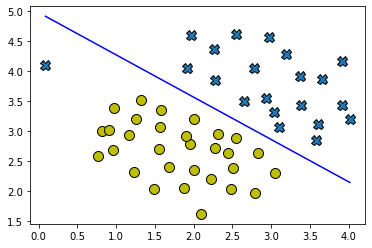

In [3]:
# Try changing the C value below to see how the decision
# boundary varies (e.g., try C = 1000)
C = 1

model = utils.svmTrain(X, y, C, utils.linearKernel, 1e-3, 20)
utils.visualizeBoundaryLinear(X, y, model)

### 1.1.2 Example Dataset 1 - using 'Pandas' and 'scikitlearn'

Before we move on to non-linear classification, I'd like to see how we'd do the same thing, but this time using more "industry standard" tools - `Pandas` and `scikitlearn` - because I'd like to get into the habit of using them.

In [4]:
# instantiate a dataframe to hold the data
data_df = pd.DataFrame(data['X'], columns=['X1', 'X2'])
data_df['y'] = data['y']

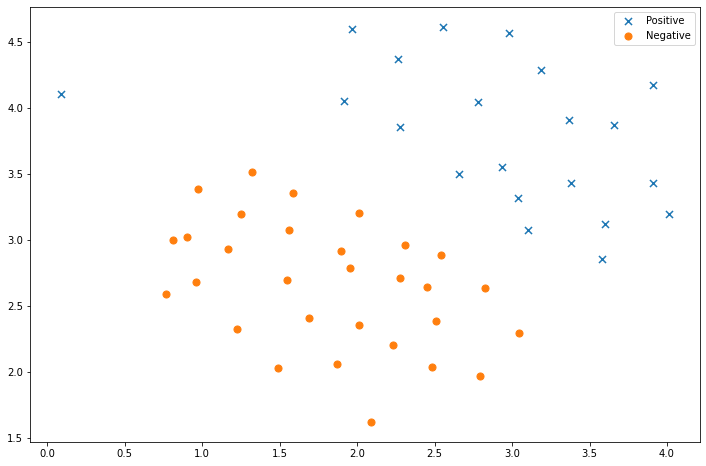

In [5]:
# distinguish the positive and negative examples and plot them
positive = data_df[data_df['y'].isin([1])]
negative = data_df[data_df['y'].isin([0])]

fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(positive['X1'], positive['X2'], s=50, marker='x', label='Positive')
ax.scatter(negative['X1'], negative['X2'], s=50, marker='o', label='Negative')
ax.legend()

Now let's instantiate a linear support vector machine from `scikitlearn` - more information on `scikitlearn`'s implementation, including the various options and parameters, can be found at: 
https://scikit-learn.org/stable/modules/svm.html

Let's instantiate two models with $C$ set to 1 and 100, and see how they perform:

In [6]:
# instantiate a linear support vector machine from scikitlearn
# ...with C = 1
svc = svm.LinearSVC(C=1, loss='hinge', max_iter=1000)
svc

LinearSVC(C=1, loss='hinge')

In [7]:
# 'fit' the model to the data
svc.fit(data_df[['X1', 'X2']], data_df['y'])
svc.score(data_df[['X1', 'X2']], data_df['y'])

/Users/Matt/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


0.9803921568627451

Let's visualise this:

Text(0.5, 1.0, 'SVM (C=1) Decision Confidence')

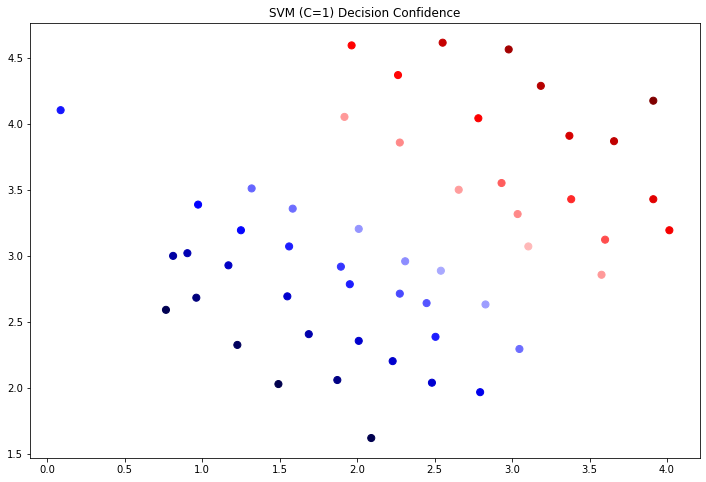

In [8]:
data_df['SVM 1 Confidence'] = svc.decision_function(data_df[['X1', 'X2']])

fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(data_df['X1'], data_df['X2'], s=50, c=data_df['SVM 1 Confidence'], cmap='seismic')
ax.set_title('SVM (C=1) Decision Confidence')

What do we see?
- Well, firstly, we see that the outlying 'positive' data point has been classified incorrectly - which is reflected in our "score" of 0.9804.
- Secondly, the colour coding of the points in the decision confidence plot reflect how "strongly" the model predicts that each point is in each class. Here all the colours are relatively dark, meaning that, even the lighter colour points are relatively far from the decision boundary.

Now let's instantiate and train a model with $C$ = 100, and see what changes:

In [9]:
# instantiate a linear support vector machine from scikitlearn
# ...with C = 1
svc2 = svm.LinearSVC(C=100, loss='hinge', max_iter=1000)
# train the model on the data
svc2.fit(data_df[['X1', 'X2']], data_df['y'])
svc2.score(data_df[['X1', 'X2']], data_df['y'])

/Users/Matt/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


1.0

Let's now plot this:

Text(0.5, 1.0, 'SVM (C=100) Decision Confidence')

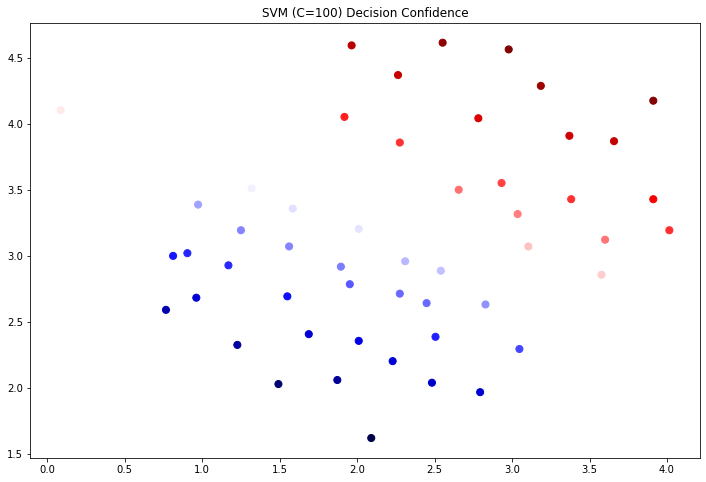

In [10]:
data_df['SVM 2 Confidence'] = svc2.decision_function(data_df[['X1', 'X2']])

fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(data_df['X1'], data_df['X2'], s=50, c=data_df['SVM 2 Confidence'], cmap='seismic')
ax.set_title('SVM (C=100) Decision Confidence')

Here we see:
- We get a "score" of exactly 1 - i.e. the model classifies all of the data points precisely as they are in the data - shown in the chart by the fact that the model now classifies the outlying "positive" data point "correctly".
- Looking at the colours of the points on the chart, some of the data points are almost white in colour, which shows that they are very close to the decision boundary.

Overall, this might indicate that setting $C$ to a value of 100 results in fitting the data very well; but potentially at a cost of over-fitting, with consequences for how well this model would fit further (previously unseen) data.

<a id="section1"></a>
### 1.2 Non-linear classsification, using SVM with Gaussian Kernels

In this part of the exercise, we will use SVMs to classify a data set is not linearly separable (i.e. that does not have a linear decision boundary). Without wanting to go too deeply into the mathematics behind this, we can think of the way this works as follows: 

- To find non-linear decision boundaries using the SVM, we first implement a "similarity" function that measures the “distance” between a pair of examples, ($x^{(i)}$, $x^{(j)}$). Such functions are also known as "kernels".

- Our kernel function projects our original data points (which are not linearly separable) onto a higher-dimensional space (via our mapping function - our kernel) in which the data points *are* linearly separable.

- We can then project the hyperplane that separates the data points in our higher-order space back onto our original space, and it becomes a non-linear decision boundary in the original space.

This is shown visually by the following illustration from Raschka and Mirjalili:

![Raschka_Kernel_Trick](Figures/Raschka_Kernel_Trick.png)

*Source: https://sebastianraschka.com/faq/docs/select_svm_kernels.html*


Professor Ng's lectures go into some detail about the maths behind this technique, so if you're interested, I'd make sure to watch these, including the "optional" videos.

#### 1.2.1 Gaussian Kernel - writing our own function
We are going to use the so-called "Gaussian" kernel, defined as:

$$ K_{\text{gaussian}} \left( x^{(i)}, x^{(j)} \right) = \exp \left( - \frac{\left\lvert\left\lvert x^{(i)} - x^{(j)}\right\lvert\right\lvert^2}{2\sigma^2} \right) = \exp \left( -\frac{\sum_{k=1}^n \left( x_k^{(i)} - x_k^{(j)}\right)^2}{2\sigma^2} \right)$$

The Gaussian kernel is parameterized by a bandwidth parameter, $\sigma$, which determines how fast the similarity metric decreases (to 0) as the examples increase in distance apart (or, decrease in "similarity").

Our task is to complete the code in `gaussianKernel` to compute the Gaussian kernel between two examples, ($x^{(i)}$, $x^{(j)}$).
<a id="gaussianKernel"></a>

In [11]:
def gaussianKernel(x1, x2, sigma):
    """
    Computes the radial basis function.
    Returns a radial basis function kernel between x1 and x2...
    ...where x1 and x2 are two *individual data points*
    
    Parameters
    ----------
    x1 :  numpy ndarray
        A vector of size (n, ), representing the first datapoint.
    
    x2 : numpy ndarray
        A vector of size (n, ), representing the second datapoint.
    
    sigma : float
        The bandwidth parameter for the Gaussian kernel.

    Returns
    -------
    sim : float
        The computed radial basis function between the two provided data points.
    """
    sim = 0.0

    # 0. calculate sum of squared differences between all points in co-ordinates    
        # version 0 - using a loop:
    for i in range(len(x1)):
        square_diff = (x1[i] - x2[i])**2
        sim += square_diff
    
        # version 1 - direct matrix operation using numpy:
    sim = np.sum((x1 - x2) ** 2)
    
    # 1. divide by (2 x sigma-squared)
    sim = sim / (2 * (sigma**2))
    
    # 2. calculate e ^ -sim
    sim = np.exp(-sim)

    return sim
    
    # Note - we could also do this in just one line, but...
    # ..."explicit is better than implicit"
    # return np.exp(-(np.sum((x1 - x2) ** 2) / (2 * (sigma ** 2))))

Let's now test our `gaussianKernel()` function on two provided examples. We should expect to see a value of 0.324652.

In [12]:
x1 = np.array([1, 2, 1])
x2 = np.array([0, 4, -1])
sigma = 2

sim = gaussianKernel(x1, x2, sigma)

print('Gaussian Kernel between x1 = [1, 2, 1], x2 = [0, 4, -1], sigma = %0.2f:'
      '\n\t%f\n(for sigma = 2, this value should be about 0.324652)\n' % (sigma, sim))

Gaussian Kernel between x1 = [1, 2, 1], x2 = [0, 4, -1], sigma = 2.00:
	0.324652
(for sigma = 2, this value should be about 0.324652)



Let's now test some further test-cases from the course's forum:

In [13]:
x3 = np.array([1, 2, 3])
x4 = np.array([2, 4, 6])
sigma = 3

sim = gaussianKernel(x3, x4, sigma)

print('Gaussian Kernel between x3 = [1, 2, 1], x4 = [0, 4, -1], sigma = %0.2f:'
      '\n\t%f\n(for sigma = 3, this value should be about 0.45943)\n' % (sigma, sim))

Gaussian Kernel between x3 = [1, 2, 1], x4 = [0, 4, -1], sigma = 3.00:
	0.459426
(for sigma = 3, this value should be about 0.45943)



Now let's try two very important test cases: points that are very close together should return approximatley 1; and points that are very distant from each other should return approximately 0:

In [14]:
x5 = np.array([1, 1, 1])
x6 = np.array([.9999, .9999, .9999])
sigma = 10

sim = gaussianKernel(x5, x6, sigma)

print('Gaussian Kernel between x5 = [1, 2, 1], x6 = [0, 4, -1], sigma = %0.2f:'
      '\n\t%f\n(for any sigma, this value should be about 1)\n' % (sigma, sim))

Gaussian Kernel between x5 = [1, 2, 1], x6 = [0, 4, -1], sigma = 10.00:
	1.000000
(for any sigma, this value should be about 1)



In [15]:
x7 = np.array([100, 100, 100])
x8 = np.array([0.00001, 0.00001, 0.00001])
sigma = 20

sim = gaussianKernel(x7, x8, sigma)

print('Gaussian Kernel between x7 = [1, 2, 1], x8 = [0, 4, -1], sigma = %0.2f:'
      '\n\t%f\n(for any sigma, this value should be about 0)\n' % (sigma, sim))

Gaussian Kernel between x7 = [1, 2, 1], x8 = [0, 4, -1], sigma = 20.00:
	0.000000
(for any sigma, this value should be about 0)



**Note** in "real-life" situations, we would be very unlikely to write our own function here - we'd use a pre-built library such as `scikitlearn`.

### 1.3 Example Dataset 2

In the next part of the exercise we load a non-linearly separable data set, and use support vector machines (SVMs) using gaussian kernel's to find a decision boundary.

The data is shown below:

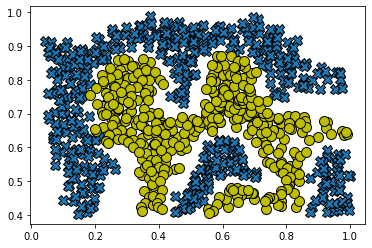

In [16]:
# Load from ex6data2
# You will have X, y as keys in the dict data
data = loadmat(os.path.join('Data', 'ex6data2.mat'))
X, y = data['X'], data['y'][:, 0]

# Plot training data using utility function provided by `dibgerge`
utils.plotData(X, y)

We can see that there is no linear decision boundary that separates the positive and negative examples for this dataset - i.e., there is no straight line that separates the two classes.

Nonetheless, by using the Gaussian kernel function that we have defined with the SVM, we will be able to learn a non-linear decision boundary that can perform reasonably well for the dataset:

Completed the function in 17.9370 seconds


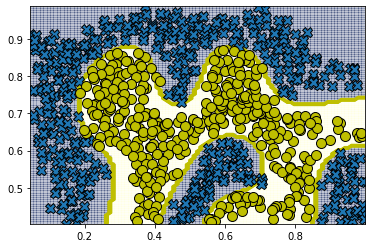

In [17]:
# set SVM Parameters
C = 1
sigma = 0.1

# create time-stamp for beginning of operation
tick = time.perf_counter()

# train SVM using our gaussianKernel function - timing the completion
model= utils.svmTrain(X, y, C, gaussianKernel, args=(sigma,))
utils.visualizeBoundary(X, y, model)

# create time-stamp for end of operation 
tock = time.perf_counter()
print("Completed the function in {:0.4f} seconds".format(tock - tick))

A few points:
- Firstly, using this utility function with this larger and non-linearly separable dataset is notably *slower* than when we used it on the smaller and linearly separable dataset - over 11 seconds!

- Secondly, it's worth trying out different values for C and sigma to see how they affect the decision boundary that results. In particular we should see that:
    - *increasing* C and/or *decreasing* $\sigma$ is likely to lead to *over-fitting* the data (low bias, high variance); and
    - *decreasing* C and/or *increasing $\sigma$ is likely to lead to *under-fitting* the data (high bias, low variance).

Let's try that and see what happens:

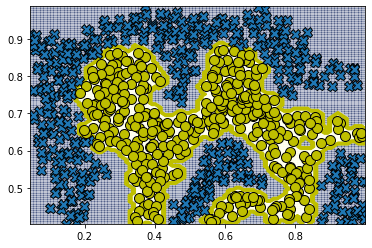

In [18]:
C = 10
sigma = 0.01

model= utils.svmTrain(X, y, C, gaussianKernel, args=(sigma,))
utils.visualizeBoundary(X, y, model)

Here, with a larger value for C and a smaller value for $\sigma$, we see just what we'd expect - a much "tighter" fit of the decision boundary around one class of points. This model may well *over-fit* the data, and have poor performance on validation or test data.

Let's try again, this time with a much smaller value of C and a larger value of $\sigma$:

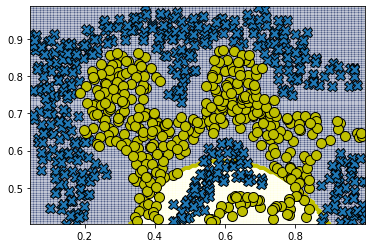

In [19]:
C = 0.25
sigma = 1

model= utils.svmTrain(X, y, C, gaussianKernel, args=(sigma,))
utils.visualizeBoundary(X, y, model)

Here we see that the model really fails to correctly classify the points. More specifically - and as we would expect given the parameters - the decision boundary fails to correctly discriminate the different classes; or put another way, the model strongly *under-fits* the data.

#### 1.3.1 Using `scikitlearn`'s implementation

Rather than writing our own functions, and using the utility functions thoughtfully provided by `dibgerge`, let's look at how we'd do this using `Pandas` and a standard machine learning library for `Python` - `scikitlearn`.

First, we'll load the data into a `Pandas` dataframe object, and plot this:

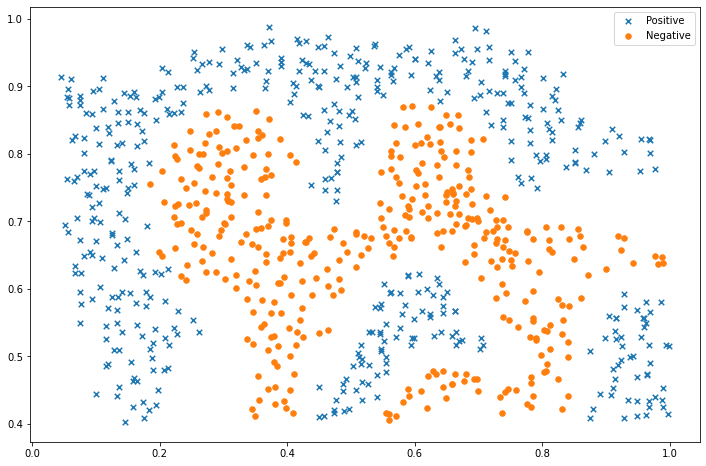

In [20]:
data_df = pd.DataFrame(data['X'], columns=['X1', 'X2'])
data_df['y'] = data['y']

positive = data_df[data_df['y'].isin([1])]
negative = data_df[data_df['y'].isin([0])]

fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(positive['X1'], positive['X2'], s=30, marker='x', label='Positive')
ax.scatter(negative['X1'], negative['X2'], s=30, marker='o', label='Negative')
ax.legend()

Now we'll train `scikitlearn`'s SVM object on the data using the built-in Gaussian (radial bias function) kernel. There, however, one important point to note about `scikitlearn`'s implementation, before we move on. In our definition of the Gaussian kernel:

$$ K_{\text{gaussian}} \left( x^{(i)}, x^{(j)} \right) = \exp \left( - \frac{\left\lvert\left\lvert x^{(i)} - x^{(j)}\right\lvert\right\lvert^2}{2\sigma^2} \right) = \exp \left( -\frac{\sum_{k=1}^n \left( x_k^{(i)} - x_k^{(j)}\right)^2}{2\sigma^2} \right)$$

The kernel is parameterized by $-1 / (2\sigma^2)$, which determines how rapidly the prediction decreases the further apart the two points are.

In `scikitlearn`'s implementation, we paramaterize the function with a constant $\gamma$. Scikitlearn explains this below:

"*Intuitively, the gamma parameter defines how far the influence of a single training example reaches, with low values meaning ‘far’ and high values meaning ‘close’.*" (https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html)

and:

"*The larger gamma is, the closer other examples must be to be affected.*" (https://scikit-learn.org/stable/modules/svm.html#svm-kernels)

Note that this operates inversely to our $\sigma$ parameter.

We can see why this is when we look at the formal definition of $\gamma$ when implementing a Gaussian kernel:

$$\gamma = 1 / \sigma^2$$

Therefore, when we use `scikitlearn`, we need to be careful to think carefully about what the impact of different values of $\gamma$ are going to do to our model. Specifically, in this case, we will need to calculate carefully what values are going to reproduce the same results we get when using our own and `dibgerge`'s functions.

I'm going to try to re-create the implementation we had above with values of `C` = 1, and $\sigma = 0.1$.

That should be equivalent to a $\gamma$ of 50 (including the fact that we defined our original parameter as **2 *times* ** sigma-squared)

We will use `scikitlearn`'s Support Vector Classification object, for which the default is to use a radial bias function (i.e. Gaussian) kernel (see https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html). 

Completed the function in 0.0504 seconds


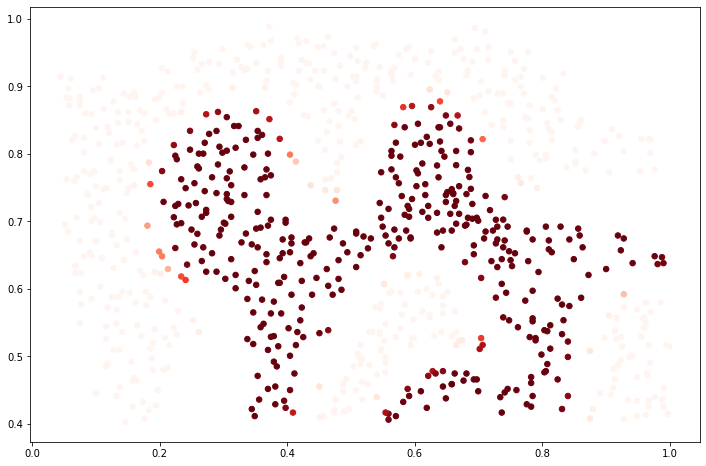

In [21]:
# create time-stamp for start of operation
tick = time.perf_counter()

# train the model
svc = svm.SVC(C=1, gamma=50, probability=True)
svc.fit(data_df[['X1', 'X2']], data_df['y'])

# plot the model
data_df['Probability'] = svc.predict_proba(data_df[['X1', 'X2']])[:,0]
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(data_df['X1'], data_df['X2'], s=30, c=data_df['Probability'], cmap='Reds')

# create time-stamp for end of operation 
tock = time.perf_counter()
print("Completed the function in {:0.4f} seconds".format(tock - tick))

OK, the charts are a bit different, so it's hard to compare exactly (and unfortunately we can't use the utility plotting function with our `scikitlearn` model).

Nonetheless, we can see that:
- The model fits the data well, with a clear decision boundary around the two classes.
- Using the `scikitlearn` implementation is ***more than 100 times faster*** than our own function (for the Gaussian kernel) combined with the code provided by `dibgerge` for training the model. Wow! That's why we should use robust machine learning libraries in practice!

<a id="section2"></a>
### 1.4 Example Dataset 3

The next part of the exercise is designed to give us further practical skills on how to use a SVM with a Gaussian kernel. We're going to use a third dataset, `ex6data3.mat`, in which we are given the variables `X`, `y`, `Xval`, `yval`, and we are going to use the cross-validation set `Xval, yval` to determine the optimal values of `C` and $\sigma$ to use.

More explicitly, for a range of potential values of `C` and $\sigma$, we are going to:
- Train our SVM (using a Gaussian kernel) on the training data;
- Use the model to predict the classification of the data points in the *cross-validation* data;
- Select the values of `C` and $\sigma$ that give us the most accurate results.

I'm going to do this in two ways:
- Firstly, as required by the exercise, I'm going to write my own code to loop over alternative values of C and $\sigma$ to find the optimal values.
- Then I'll use `scikitlearn` to do the same thing, faster!

Let's start by loading the data:

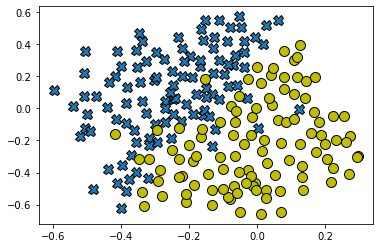

In [22]:
# Load from ex6data3
# You will have X, y, Xval, yval as keys in the dict data
data = loadmat(os.path.join('Data', 'ex6data3.mat'))
X, y, Xval, yval = data['X'], data['y'][:, 0], data['Xval'], data['yval'][:, 0]

# Plot training data
utils.plotData(X, y)

#### 1.4.1 - Our Own Implementation

The aim of the next part of the exercise is to adapt `dataset3Params()` to find and return the optimal values for `C` and $\sigma$.

The exercise "suggests" [requires, really] that we try values in multiplicative steps (e.g., 0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100) for both $C$ and $\sigma$ - trying all possible pairs of values.

Thus, if we try each of the 8 values listed above for $C$ and for $\sigma^2$, we will end up training and evaluating (on the cross validation set) a total of $9^2 = 81$ different models.

<div class="alert alert-block alert-warning">
**Implementation Tip:** When implementing cross validation to select the best $C$ and $\sigma$ parameter to use, we need to evaluate the error on the cross validation set. Recall that for classification, the error is defined as the fraction of the cross validation examples that were classified incorrectly. If we're not using `scikitlearn`, we can use the `utils.svmPredict` function to generate the predictions for the cross validation set.
</div>
<a id="dataset3Params"></a>

In [23]:
def dataset3Params(X, y, Xval, yval):
    """
    Returns the optimal values of choice of C and sigma to use for SVM...
    ...with an RBF kernel for Part 3 of the exercise.
    
    Parameters
    ----------
    X : array_like
        (m x n) matrix of training data where m is number of training examples, and 
        n is the number of features.
    
    y : array_like
        (m, ) vector of labels for ther training data.
    
    Xval : array_like
        (mv x n) matrix of validation data where mv is the number of validation examples
        and n is the number of features
    
    yval : array_like
        (mv, ) vector of labels for the validation data.
    
    Returns
    -------
    C, sigma : float, float
        The best performing values for the regularization parameter C and 
        RBF parameter sigma.
    """
    C_values = [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100] # [1] (test value)
    sigma_values = [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100] # [0.1] (test value)

    best_score = 0
    best_params = {'C': None, 'sigma': None}

    for C in C_values:
        for sigma in sigma_values:
            # train model
            model = utils.svmTrain(X, y, C, gaussianKernel, args=(sigma,))
            # predict class
            predictions = utils.svmPredict(model, Xval)
            # calculate % correct classifications
            score = np.mean(predictions == yval)
            # check whether this is best score so far,...
            # ...if so, store parameters that caused it
            if score > best_score:
                best_score = score
                best_params['C'] = C
                best_params['sigma'] = sigma

    C, sigma = best_params.values()
    
    print("Best score is {}".format(best_score))
    print("Best value for C is {}".format(C))
    print("Best value for sigma is {}".format(sigma))
    
    return C, sigma

The code in the next cell trains the SVM classifier using the training set `(X, y)` using the range of potential parameters set out for `C` and $\sigma$ set out in `dataset3Params()`, and then plots the decision boundary. Note that this might take a few minutes to execute.

Best score is 0.965
Best value for C is 1
Best value for sigma is 0.1


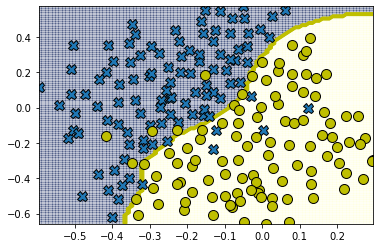

In [24]:
# Try different SVM Parameters here
C, sigma = dataset3Params(X, y, Xval, yval)

# Train the SVM
# model = utils.svmTrain(X, y, C, lambda x1, x2: gaussianKernel(x1, x2, sigma))
model = utils.svmTrain(X, y, C, gaussianKernel, args=(sigma,))
utils.visualizeBoundary(X, y, model)

#### 1.4.2 Using `scikitlearn`

Now let's achieve the same outcome, using `scikitlearn`'s pre-built methods. For reference, this section draws heavily on the `scikitlearn` tutorial at: https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html

Remember that we parameterize `scikitlearn`'s methods using the parameter $\gamma$, which is akin to the inverse of $\sigma$.

Therefore the first thing we need to do, if we want to try to get comparable results, is convert our $\sigma$ values into appropriate values for $\gamma$.

In [1]:
# convert sigma values into gamma values
sigma_values = [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100]
gamma_range = [(1/(2*(sigma**2))) for sigma in sigma_values]

# define range of values for C
C_range = [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100]

In [3]:
print (gamma_range)

[5000.0, 555.5555555555555, 49.99999999999999, 5.555555555555555, 0.5, 0.05555555555555555, 0.005, 0.0005555555555555556, 5e-05]


In [26]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit

parameters = {'C': C_range, 'gamma': gamma_range}
svc = svm.SVC()
cv = StratifiedShuffleSplit(n_splits=10, test_size=0.1, random_state=42)
clf = GridSearchCV(svc, parameters, cv=cv)
clf.fit(X, y)

print("The best parameters are %s with a cross-validation score of %0.2f"
      % (clf.best_params_, clf.best_score_))

The best parameters are {'C': 30, 'gamma': 5.555555555555555} with a cross-validation score of 0.95


Now let's create a heatmap of the validation accuracy as a function of `C` and $\gamma$

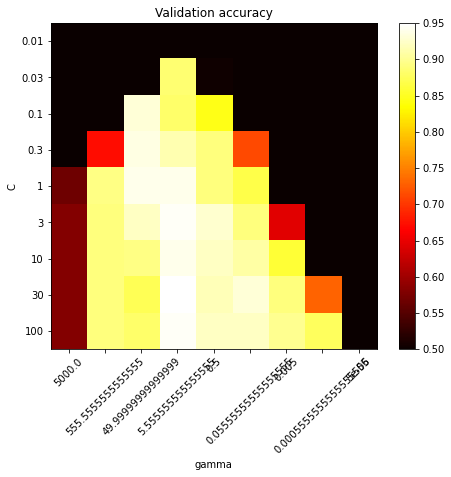

In [27]:
# Draw heatmap of the validation accuracy as a function of C and gamma
# The accuracy score are encoded as colors with the hot colormap which varies from dark
# red to bright yellow. 

# extract the scores:
scores = clf.cv_results_['mean_test_score'].reshape(len(C_range), len(gamma_range))

# plot the scores
plt.figure(figsize=(8, 6))
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot) # norm=MidpointNormalize(vmin=0.2, midpoint=0.92))
plt.xlabel('gamma')
plt.ylabel('C')
plt.colorbar()
plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
plt.yticks(np.arange(len(C_range)), C_range)
plt.title('Validation accuracy')
plt.show()

Phew! That x-axis is ugly! However, I've just spent about half an hour trying to figure out how to set the tick-labels to be in scientific notation (i.e. multiples of power of 10), and I can't work it out, so I'm going to move on.

For future reference, if I come back to tidy the chart up, I might start by looking at https://matplotlib.org/3.1.0/gallery/ticks_and_spines/scalarformatter.html 

Now let's take a look at how good the decision boundary is with our optimal parameters:

In [28]:
clf = SVC(C = 30, gamma = 5.55555555)
clf.fit(X, y)
clf.score(X, y)

0.9383886255924171

So, where are we? We've trained a bunch of SVM models on our data, using 81 different combinations of `C` and $\gamma$. We've run cross-validation on each of them, and determined that the most accurate model is when our paramaters are:
- $C$ = 30, and
- $\gamma$ = 5.5555

When we score these parameters on our training data-set, we get an accuracy score of 94%

Now, to be consistent with what we did above in terms of training and validation, we should train our model (i.e. a non-linear SVM with a Gaussian kernel, with these values of `C` and $\gamma$) on the *validation* data set, and see what accuracy we achieve. Let's do that:

In [29]:
clf = SVC(C = 30, gamma = 5.55555555)
clf.fit(Xval, yval)
clf.score(Xval, yval)

0.96

So, we get 96% accuracy on the validation data - pretty good. We might be able to do a bit better with further tuning of the parameters, but that will do for now. Worth noting, however, that our accuracy score on the *validation* set (96%) is *higher* than our score on the training set (94%) - which is, well, a bit weird. Hmm. Well, I'm going to move on.

<a id="section3"></a>
## 2 Spam Classification

Many email services today provide spam filters that are able to classify emails into spam and non-spam email with high accuracy. In this part of the exercise, we will use SVMs to build your own spam filter.

We will be training a classifier to classify whether a given email, $x$, is spam ($y = 1$) or non-spam ($y = 0$). To enable this, we need to convert each email into a feature vector $x \in \mathbb{R}^n$ . The following parts of the exercise will walk us through how such a feature vector can be constructed from an email.

The dataset included for this exercise is based on a a subset of the [SpamAssassin Public Corpus](http://spamassassin.apache.org/old/publiccorpus/). For the purpose of this exercise, we will only be using the body of the email (excluding the email headers).

### 2.1 Preprocessing Emails

Before starting on a machine learning task, it is usually insightful to take a look at examples from the dataset. The figure below shows a sample email that contains a URL, an email address (at the end), numbers, and dollar
amounts.

<img src="Figures/email.png" width="700px" />

While many emails would contain similar types of entities (e.g., numbers, other URLs, or other email addresses), the specific entities (e.g., the specific URL or specific dollar amount) will be different in almost every
email. Therefore, one method often employed in processing emails is to “normalize” these values, so that all URLs are treated the same, all numbers are treated the same, etc. For example, we could replace each URL in the
email with the unique string “httpaddr” to indicate that a URL was present.

This has the effect of letting the spam classifier make a classification decision based on whether any URL was present, rather than whether a specific URL was present. This typically improves the performance of a spam classifier, since spammers often randomize the URLs, and thus the odds of seeing any particular URL again in a new piece of spam is very small. 

In the function `processEmail` below, the course's designers, and/or our friend `dibgerge`, have *already* implemented the following email preprocessing and normalization steps:

- **Lower-casing**: The entire email is converted into lower case, so that captialization is ignored (e.g., IndIcaTE is treated the same as Indicate).

- **Stripping HTML**: All HTML tags are removed from the emails. Many emails often come with HTML formatting; we remove all the HTML tags, so that only the content remains.

- **Normalizing URLs**: All URLs are replaced with the text “httpaddr”.

- **Normalizing Email Addresses**:  All email addresses are replaced with the text “emailaddr”.

- **Normalizing Numbers**: All numbers are replaced with the text “number”.

- **Normalizing Dollars**: All dollar signs ($) are replaced with the text “dollar”.

- **Word Stemming**: Words are reduced to their stemmed form. For example, “discount”, “discounts”, “discounted” and “discounting” are all replaced with “discount”. Sometimes, the Stemmer actually strips off additional characters from the end, so “include”, “includes”, “included”, and “including” are all replaced with “includ”.

- **Removal of non-words**: Non-words and punctuation have been removed. All white spaces (tabs, newlines, spaces) have all been trimmed to a single space character.

The result of these preprocessing steps is shown in the figure below. 

<img src="Figures/email_cleaned.png" alt="email cleaned" style="width: 600px;"/>

While preprocessing has left word fragments and non-words, this form turns out to be much easier to work with for performing feature extraction.

#### 2.1.1 Vocabulary List

After preprocessing the emails, we have a list of words for each email. The next step is to choose which words we would like to use in our classifier and which we would want to leave out.

For this exercise, the course has chosen only the most frequently occuring words as our set of words considered (the vocabulary list). Since words that occur rarely in the training set are only in a few emails, they might cause the model to overfit our training set. The complete vocabulary list is in the file `vocab.txt` (inside the `Data` directory for this exercise) and also shown in the figure below.

<img src="Figures/vocab.png" alt="Vocab" width="150px" />

Our vocabulary list was selected by choosing all words which occur at least a 100 times in the spam corpus,
resulting in a list of 1899 words. In practice, a vocabulary list with about 10,000 to 50,000 words is often used.
Given the vocabulary list, we can now map each word in the preprocessed emails into a list of word *indices* that contains the index of the word in the vocabulary dictionary. The figure below shows the mapping for the sample email. Specifically, in the sample email, the word “anyone” was first normalized to “anyon” and then mapped onto the index 86 in the vocabulary list.

<img src="Figures/word_indices.png" alt="word indices" width="200px" />

Our task at this stage is simply to complete the code in the function `processEmail` to perform this mapping. In the code, we are given a string `word` which is a single word from the processed email. We are to look up the word in the vocabulary list `vocabList`. If the word exists in the list, we must add the *index* of the word into the `word_indices` list. If the word does not exist, and is therefore not in the vocabulary, we can skip the word.

<div class="alert alert-block alert-warning">
**python tip**: In python, you can find the index of the first occurence of an item in `list` using the  `index` attribute. In the provided code for `processEmail`, `vocabList` is a python list containing the words in the vocabulary. To find the index of a word, we can use `vocabList.index(word)` which would return a number indicating the index of the word within the list. If the word does not exist in the list, a `ValueError` exception is raised. In python, we can use the `try/except` statement to catch exceptions which we do not want to stop the program from running. You can think of the `try/except` statement to be the same as an `if/else` statement, but it asks for forgiveness rather than permission.

An example would be:
<br>

```
try:
    do stuff here
except ValueError:
    pass
    # do nothing (forgive me) if a ValueError exception occured within the try statement
```
</div>
<a id="processEmail"></a>

In [30]:
def processEmail(email_contents, verbose=True):
    """
    Preprocesses the body of an email and returns a list of indices 
    of the words contained in the email.    
    
    Parameters
    ----------
    email_contents : str
        A string containing one email. 
    
    verbose : bool
        If True, print the resulting email after processing.
    
    Returns
    -------
    word_indices : list
        A list of integers containing the index of each word in the 
        email which is also present in the vocabulary.
    """
    # Load Vocabulary
    vocabList = utils.getVocabList()

    # Initialize list of word indices to be returned
    word_indices = []

    # ========================== Preprocess Email ===========================
    # Find the Headers ( \n\n and remove )
    # Uncomment the following lines if you are working with raw emails with the
    # full headers
    # hdrstart = email_contents.find(chr(10) + chr(10))
    # email_contents = email_contents[hdrstart:]

    # Lower case
    email_contents = email_contents.lower()
    
    # Strip all HTML
    # Looks for any expression that starts with < and ends with > and replace
    # and does not have any < or > in the tag it with a space
    email_contents =re.compile('<[^<>]+>').sub(' ', email_contents)

    # Handle Numbers
    # Look for one or more characters between 0-9
    email_contents = re.compile('[0-9]+').sub(' number ', email_contents)

    # Handle URLS
    # Look for strings starting with http:// or https://
    email_contents = re.compile('(http|https)://[^\s]*').sub(' httpaddr ', email_contents)

    # Handle Email Addresses
    # Look for strings with @ in the middle
    email_contents = re.compile('[^\s]+@[^\s]+').sub(' emailaddr ', email_contents)
    
    # Handle $ sign
    email_contents = re.compile('[$]+').sub(' dollar ', email_contents)
    
    # get rid of any punctuation
    email_contents = re.split('[ @$/#.-:&*+=\[\]?!(){},''">_<;%\n\r]', email_contents)

    # remove any empty word string
    email_contents = [word for word in email_contents if len(word) > 0]
    
    # Stem the email contents word by word
    stemmer = utils.PorterStemmer()
    processed_email = []
    for word in email_contents:
        # Remove any remaining non alphanumeric characters in word
        word = re.compile('[^a-zA-Z0-9]').sub('', word).strip()
        word = stemmer.stem(word)
        processed_email.append(word)

        if len(word) < 1:
            continue

        ### OUR CODE ###
        # Look up the word in the dictionary and add to word_indices if found
        try:
            index = vocabList.index(word)
            word_indices.append(index)
        except ValueError:
            pass
        ### OUR CODE ENDS ###

    if verbose:
        print('----------------')
        print('Processed email:')
        print('----------------')
        print(' '.join(processed_email))
    return word_indices

The following cell runs the code for `processEmail()` on the email sample and produces an output of the processed email and the indices list mapping.

In [31]:
# Extract Features
with open(os.path.join('Data', 'emailSample1.txt')) as fid:
    file_contents = fid.read()

word_indices = processEmail(file_contents)

#Print Stats
print('-------------')
print('Word Indices:')
print('-------------')
print(word_indices)

----------------
Processed email:
----------------
anyon know how much it cost to host a web portal well it depend on how mani visitor your expect thi can be anywher from less than number buck a month to a coupl of dollar number you should checkout httpaddr or perhap amazon ec number if your run someth big to unsubscrib yourself from thi mail list send an email to emailaddr
-------------
Word Indices:
-------------
[85, 915, 793, 1076, 882, 369, 1698, 789, 1821, 1830, 882, 430, 1170, 793, 1001, 1894, 591, 1675, 237, 161, 88, 687, 944, 1662, 1119, 1061, 1698, 374, 1161, 476, 1119, 1892, 1509, 798, 1181, 1236, 511, 1119, 809, 1894, 1439, 1546, 180, 1698, 1757, 1895, 687, 1675, 991, 960, 1476, 70, 529, 1698, 530]


<a id="section4"></a>
### 2.2 Extracting Features from Emails

You will now implement the feature extraction that converts each email into a vector in $\mathbb{R}^n$. For this exercise, you will be using n = # words in vocabulary list. Specifically, the feature $x_i \in \{0, 1\}$ for an email corresponds to whether the $i^{th}$ word in the dictionary occurs in the email. That is, $x_i = 1$ if the $i^{th}$ word is in the email and $x_i = 0$ if the $i^{th}$ word is not present in the email.

Thus, for a typical email, this feature would look like:

$$ x = \begin{bmatrix} 
0 & \dots & 1 & 0 & \dots & 1 & 0 & \dots & 0 
\end{bmatrix}^T \in \mathbb{R}^n
$$

You should now complete the code in the function `emailFeatures` to generate a feature vector for an email, given the `word_indices`.
<a id="emailFeatures"></a>

In [32]:
def emailFeatures(word_indices):
    """
    Takes in a word_indices vector and produces a feature vector from the word indices. 
    
    Parameters
    ----------
    word_indices : list
        A list of word indices from the vocabulary list.
    
    Returns
    -------
    x : numpy array 
        The computed feature vector.
    
    Notes
    ------------
    We have already pre-processed each email and converted
    each word in the email into an index in a fixed dictionary (of 1899 words).
    The variable `word_indices` contains the list of indices of the words 
    which occur in one email.
    Concretely, if an email has the text:

        The quick brown fox jumped over the lazy dog.

    Then, the word_indices vector for this text might look like:
               
        60  100   33   44   10     53  60  58   5

    where we have mapped each word onto a number, for example:

        the   -- 60
        quick -- 100
        ...etc.

    In our feature vector, x, x[i] = 1 when word i is present in the email.
    Concretely, if the word 'the' (say, index 60) appears in the email,
    then x[60] = 1.
    """
    # total number of words in the dictionary
    n = 1899
    # instantiate a numpy array filled with zeros as our feature vector
    x = np.zeros(n)
    # add a 1 at the index position of every word in the email
    for index in word_indices:
        x[index] = 1
    
    return x

We can test our implementaiton of `emailFeatures` using a test case provided for us.

The next cell will run our code on the provided email sample. We should see that the feature vector has length 1899 and 45 non-zero entries.

In [33]:
# Extract Features
with open(os.path.join('Data', 'emailSample1.txt')) as fid:
    file_contents = fid.read()

word_indices  = processEmail(file_contents)
features      = emailFeatures(word_indices)

# Print Stats
print('\nLength of feature vector: %d' % len(features))
print('Number of non-zero entries: %d' % sum(features > 0))

----------------
Processed email:
----------------
anyon know how much it cost to host a web portal well it depend on how mani visitor your expect thi can be anywher from less than number buck a month to a coupl of dollar number you should checkout httpaddr or perhap amazon ec number if your run someth big to unsubscrib yourself from thi mail list send an email to emailaddr

Length of feature vector: 1899
Number of non-zero entries: 45


Looks good!

### 2.3 Training SVM for Spam Classification

In the following section we will load a preprocessed training dataset that will be used to train a SVM classifier. The file `spamTrain.mat` (within the `Data` folder for this exercise) contains 4000 training examples of spam and non-spam email, while `spamTest.mat` contains 1000 test examples. Each
original email was processed using the `processEmail` and `emailFeatures` functions and converted into a vector $x^{(i)} \in \mathbb{R}^{1899}$.

#### 2.3.1 - Using the Utility Functions Provided

After loading the dataset, the next cell uses the utility functions provided by the course/adapted into `Python` by `dibgerge` to train a linear SVM to classify spam ($y = 1$) and non-spam ($y = 0$) emails.

Once the training completes, we will see that the classifier gets a training accuracy of about 99.8% and a test accuracy of about 98.5%.

For fun and learning, I've put a timer around the function so we can see how long it takes; and later compare it to our `scikitlearn` implementation.

In [34]:
# Load the Spam Email dataset
# You will have X, y in your environment
data = loadmat(os.path.join('Data', 'spamTrain.mat'))
X, y= data['X'].astype(float), data['y'][:, 0]

print('Training Linear SVM (Spam Classification)')
print('This may take 1 to 2 minutes ...\n')

C = 0.1

# create time-stamp for start of operation
tick = time.perf_counter()

# train the model
model = utils.svmTrain(X, y, C, utils.linearKernel)

# create time-stamp for end of operation 
tock = time.perf_counter()
print("Completed the function in {:0.4f} seconds".format(tock - tick))

Training Linear SVM (Spam Classification)
This may take 1 to 2 minutes ...

Completed the function in 180.2551 seconds


Now let's look at the training accuracy of the model:

In [35]:
# Compute the training accuracy
p = utils.svmPredict(model, X)
print('Training Accuracy: %.2f' % (np.mean(p == y) * 100))

Training Accuracy: 99.85


Finally let's load the test set and compute the validation accuracy:

In [36]:
# Load the test dataset
# You will have Xtest, ytest in your environment
data = loadmat(os.path.join('Data', 'spamTest.mat'))
Xtest, ytest = data['Xtest'].astype(float), data['ytest'][:, 0]

print('Evaluating the trained Linear SVM on a validation set ...')
p = utils.svmPredict(model, Xtest)

print('Test Accuracy: %.2f' % (np.mean(p == ytest) * 100))

Evaluating the trained Linear SVM on a validation set ...
Test Accuracy: 98.90


#### 2.3.2 Using `scikitlearn`

In [37]:
# set C to be the same as the utility function
C = 0.1

# create time-stamp for start of operation
tick = time.perf_counter()

# instantiate and train the model with linear kernel...
# ...and gamma parameter set automatically
clf = SVC(C=C, gamma='auto', kernel='linear')
clf.fit(X, y)

# create time-stamp for end of operation 
tock = time.perf_counter()
print("Completed the function in {:0.4f} seconds".format(tock - tick))

Completed the function in 5.4980 seconds


Now let's look at the training accuracy of the model:

In [38]:
accuracy = clf.score(X, y)
print("Training accuracy: {:0.5f}".format(accuracy))

Training accuracy: 0.99825


Now let's calculate the accuracy on the validation data:

In [39]:
accuracy = clf.score(Xtest, ytest)
print("Validation accuracy: {:0.5f}".format(accuracy))

Validation accuracy: 0.98900


**What can we conclude from this comparison of `scikitlearn` and the utility functions?**
- Well, both produce >99.8% accuracy on the training data, and >98.7% accuracy on the validation data - so both perform well.
- The `scikitlearn` implementation, however, is around 25 times faster to train - which is a valuable improvement!
- Finally, if I were to come back to re-use this code for a future project, I'd much rather rely on `scikitlearn`'s robust, documented and *maintained* library than the utility functions.

### 2.4 Top Predictors for Spam

To better understand how the spam classifier works, we can inspect the parameters to see which words the classifier thinks are the most predictive of spam. The next cell finds the parameters with the largest positive values in the classifier and displays the corresponding words similar to the ones shown in the figure below.

<div style="border-style: solid; border-width: 1px; margin: 10px 10px 10px 10px; padding: 10px 10px 10px 10px">
our  click  remov guarante visit basenumb dollar pleas price will nbsp most lo ga hour
</div>

Thus, if an email contains words such as “guarantee”, “remove”, “dollar”, and “price” (the top predictors shown in the figure), it is likely to be classified as spam.

Since the model we are training is a linear SVM, we can inspect the weights learned by the model to understand better how it is determining whether an email is spam or not. The following code finds the words with the highest weights in the classifier. Informally, the classifier 'thinks' that these words are the most likely indicators of spam.

In [40]:
# Sort the weights and obtain the vocabulary list
# NOTE some words have the same weights, 
# so their order might be different than in the text above
idx = np.argsort(model['w'])
top_idx = idx[-15:][::-1]
vocabList = utils.getVocabList()

print('Top predictors of spam:')
print('%-15s %-15s' % ('word', 'weight'))
print('----' + ' '*12 + '------')
for word, w in zip(np.array(vocabList)[top_idx], model['w'][top_idx]):
    print('%-15s %0.2f' % (word, w))


Top predictors of spam:
word            weight         
----            ------
our             0.50
click           0.47
remov           0.42
guarante        0.38
visit           0.37
basenumb        0.35
dollar          0.33
will            0.28
price           0.26
pleas           0.26
nbsp            0.26
most            0.26
lo              0.26
hour            0.24
da              0.24
